## 2: Pré-processamento & Modelagem

Pré-processamento do dataset: *Credit Card Fraud Detection*.

**Link**: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Modelos avaliados: *Random Forest* & *Logistic Regression*

---
### 1️⃣ Importando Bibliotecas & Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Salvar modelo treinado
import joblib
import os
from datetime import datetime

# Data preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Strategies
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Silenciar avisos na célula de treinamento
import warnings
warnings.filterwarnings("ignore")

In [49]:
# Carregar dados
df = pd.read_csv("train.csv")

---
### 2️⃣ Pré-processamento
> Aplicação dos resultados avaliados no EDA

##### 📍 Feature Engineering

1. Criação da Coluna `is_zero_amount`
2. Transformações circulares na coluna `Time`

In [ ]:
"""
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # 1. Criar is_zero_amount
        if "Amount" in X_copy.columns:
            X_copy["is_zero_amount"] = (X_copy["Amount"] == 0).astype(int)
        
        # 2. Transformações de Tempo (Seno/Cosseno)
        if "Time" in X_copy.columns:
            hour = (X_copy["Time"] // 3600) % 24
            X_copy["hour_sin"] = np.sin(2 * np.pi * hour / 24)
            X_copy["hour_cos"] = np.cos(2 * np.pi * hour / 24)
            
            # 3. Drop das colunas originais que não serão usadas pelo modelo
            X_copy = X_copy.drop(["Time"], axis=1)
            
        return X_copy
    
feature_eng_step = FeatureEngineer()
"""

Ao aplicar esse Feature Engineering houve uma melhora em todos os modelos iniciais do *Logistic Regression* e do *Random Forest*, tornando inclusive o baseline bem competitivo, embora ainda pior que o melhor modelo do RF.

E especialmente, o ganho substancial no modelo linear, demonstra que essas features realmente capturam relações lineares valiosas.

Contudo, ao tentar potencializar esses resultados no modelo do *XGBoost*, embora ele também apresente uma melhora em relação ao melhor modelo do RF, o desempenho ainda é inferior ao XGB treinado sem essas transformações nas features.

O que evidencia que para esse modelo mais complexo, o conjunto de dados padrão é informativo o suficiente para gerar uma ótima fronteira de decisão, essas features modificadas apenas adicionam redudância, que pela depreciação do resultado final, inserem ruídos prejudiciais.

> Por fim, não foi utilizado essas features planejadas durante o EDA, pois não se comprovou o aumento no poder preditivo do melhor modelo global

##### 📍 Remoção dos outliers extremos

In [ ]:
"""
import numpy as np

def remove_extreme_outliers(X, y, features=["V14","V12"], factor=3):

    X_res, y_res = X.copy(), y.copy()

    for feat in features:
        fraud_data = X_res[y_res == 0][feat]
        q25, q75 = np.percentile(fraud_data, 25), np.percentile(fraud_data, 75)
        iqr = q75 - q25
        cut_off = iqr * factor
        lower, upper = q25 - cut_off, q75 + cut_off
        
        outliers = X_res[(y_res == 1) & ((X_res[feat] < lower) | (X_res[feat] > upper))].index
        X_res = X_res.drop(outliers)
        y_res = y_res.drop(outliers)
    return X_res, y_res

# Removendo outliers
X_train_out, y_train_out = remove_extreme_outliers(X_train, y_train)

print(f"Dataset reduzido em {len(X_train) - len(X_train_out)} outliers.")
"""

Ao aplicar a remoção de outliers extremos das features `V12` & `V14`, da classe *Não Fraude* (totalizando 266 outliers, com um fator de 3 para amenizar o corte), que "invadia" a região da classe *Fraude*, todos os modelos apresentaram uma depreciação significativa.

Isso demonstra, que os pontos anteriormente identificados como ruídosos, na verdade eram casos de fronteira, muito importantes para a definir a fronteira de decisão dos modelos, permitindo que eles consigam distinguir uma *Não fraude incomum* de uma *Não Fraude real*.

> No modelo final, não foi utilizado essa função de remoção dos outliers, e obteve-se um desempenho muito superior.

---

##### 📍 RobustScaler na coluna `Amount`

In [ ]:
# Escalonamento
preprocessor = ColumnTransformer(transformers=[
    ('std_scaler', StandardScaler(), ['Time']), # Scaler aplicado pois não tem transformação da coluna "Time"
    ("rob_scaler", RobustScaler(), ["Amount"])
], remainder="passthrough")

In [41]:
# Split dos dados

X = df.drop(["Class", "id"], axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

---
### 3️⃣ Pipelines (Múltiplas Abordagens) & Treinamentos

- Modelo linear: *Logistic Regression* escolhido como Baseline, pois como a análise do Notebook de EDA sugere, seu desempenho nesse dataset não deve ser muito elevado.

- Modelo baseado em árvore: *Random Forest* escolhido por sua robustez contra desbalanceamento.

In [52]:
# Definindo validação cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hiperparâmetros para Logistic Regression
param_grid_lr = {
    "classifier__C": [00.1, 0.1, 1, 10, 100],
    "classifier__solver": ["lbfgs", "saga"],
    "classifier__class_weight": [None, "balanced"]
}

# Hiperparâmetros para Random Forest
param_grid_rf = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__class_weight": [None, "balanced"],
}

# Função para aplicar GridSearch em todos os modelos
def run_experiment(name, sampler, model, params):
    print(f"Executando: {name}...")

    pipeline = Pipeline([
        #("feature_eng", feature_eng_step),
        ("preprocessor", preprocessor),
        ("sampler", sampler),
        ("classifier", model)
    ])

    grid = GridSearchCV(pipeline, params, cv=skf, scoring="roc_auc", n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    return grid

In [53]:
# Estrutura para armazenar os melhores modelos e resultados
results = {}

print(f"Iniciando treinamentos...\n")

lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)

# 1. Baseline sem sampler (Apenas pesos)
results["LR_Weight"] = run_experiment("LR_Weight", "passthrough", lr, param_grid_lr)
results["RF_Weight"] = run_experiment("RF_Weight", "passthrough", rf, param_grid_rf)

# 2. RandomUnderSampling (Undersampling) + Pesos
results["LR_RUS"] = run_experiment("LR_RUS", RandomUnderSampler(random_state=42), lr, param_grid_lr)
results["RF_RUS"] = run_experiment("RF_RUS", RandomUnderSampler(random_state=42), rf, param_grid_rf)

# 3. Oversampling com SMOTE
results["LR_SMOTE"] = run_experiment("LR_SMOTE", SMOTE(sampling_strategy=0.2, random_state=42), lr, param_grid_lr)
results["RF_SMOTE"] = run_experiment("RF_SMOTE", SMOTE(sampling_strategy=0.2, random_state=42), rf, param_grid_rf)

Iniciando treinamentos...

Executando: LR_Weight...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Executando: RF_Weight...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Executando: LR_RUS...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Executando: RF_RUS...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Executando: LR_SMOTE...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Executando: RF_SMOTE...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


---
#### 📝 Sobre os Hiperparâmetros

- Testei aumentar o `classifier__n_estimators` para até 200, porém a diferença foi insignificante e o tempo de treinamento aumentou drásticamente.

- O modelo de Random Forest também possui uma opção de `class_weight` chamada `balanced_subsample`, que balanceia os dados de cada árvore individualmente, visto que cada árvore é treinada com um conjunto do dados, mas isso tende a piorar o desempenho do modelo em situações com alto desbalanceamento, pois é possível ocorrer árvores com quase nenhum dado da classe minoritária (ainda sim foi testado e o GridSearch achou resultados melhores com o `balanced` padrão).

- O modelo de *Logistic Regression* é treinado mais rapidamente e tende a ter o pior desempenho. Dessa forma, buscando extrair o máximo do seu potencial foi colocado uma lista de vários valores para o `classifier__C`.

- O `SMOTE` não foi usado em sua totalidade, pelo desbalanceamento muito grande do dataset, ocasionava a geração de muitos dados sintéticos, que além de aumentar muito o tempo de treinamento, diminuía o desempenho pela criação de dados pouco representativos da realidade (testei valores que não aumentassem muito o tempo de treinamento e apresentassem uma melhora significativa no `ROC-AUC`).

---
### 4️⃣ Avaliação & Comparação
> Métrica comparativa: ROC-AUC

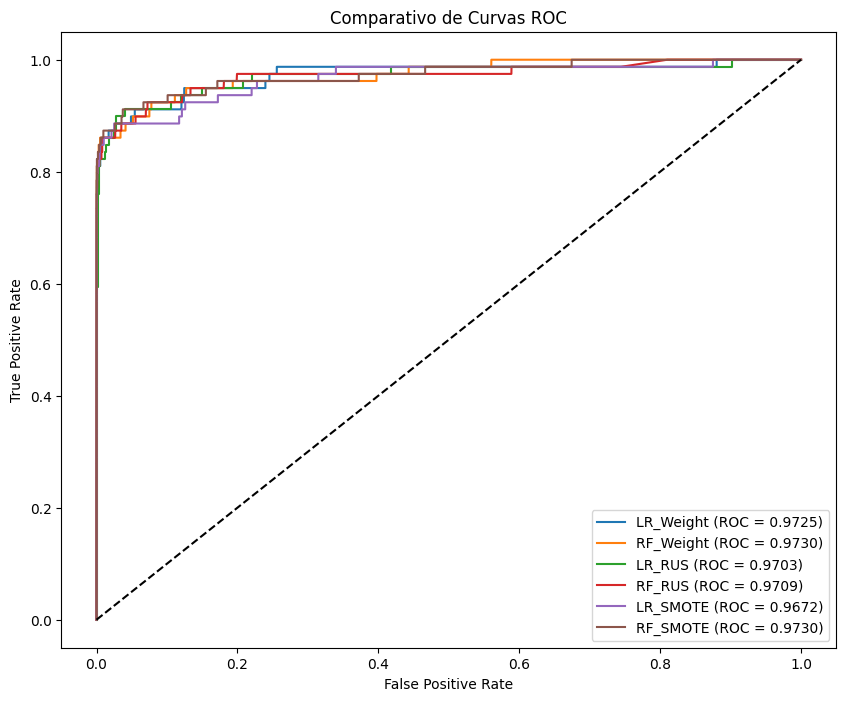

O melhor modelo foi RF_Weight com ROC 0.9730


In [54]:
best_roc = 0
best_model_name = ""

plt.figure(figsize=(10, 8))

for name, model in results.items():

    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (ROC = {roc:.4f})")

    if roc > best_roc:
        best_roc = roc
        best_model_name = name

# Gráfico   
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparativo de Curvas ROC")
plt.legend()
plt.show()

print(f"O melhor modelo foi {best_model_name} com ROC {best_roc:.4f}")

---
#### 💬 Análise sobre desempenho dos modelos

Como era de se esperar o modelo de *Random Forest* superou o baseline em todas das abordagens, mesmo que na maioria de forma pequena, sugerindo que a simplicidade do modelo de LR foi mais estável do que o esperado para esse dataset.

O modelo principal obteve o melhor resultado global com `SMOTE`, que foi o pior resultado para o baseline, insinuando que os exemplos sintéticos auxiliaram o modelo de árvore a "mapear" melhor as fronteiras de decisões não lineares da classe minoritária, que já era uma fraqueza nítida do modelo linear.

Além disso, o RF também teve um desempenho equivalente ao uso de `SMOTE` com o uso de pesos no treinamento, demonstrando que possivelmente os dados sintéticos gerados apenas reforçaram a importância da classe minoritária, que o peso balanceado já conseguia conferir as amostras reais.

Por fim, os resultados com o `RandomUnderSampling` não foram descartáveis, indicando que a remoção de exemplos da classe majoritária não causou uma depreciação nas fronteiras de decisão dos modelos, com resultados competitivos entre o modelo principal e o baseline.

---
#### ➕ Treinamento de Modelo Extra

O XGBoost é um modelo que também faz parte dos modelos baseados em árvores, assim como o *Random Forest*, que desde a análise do EDA, já demonstrava um potencial maior de desempenho, em relação ao baseline: *Logistic Regression*.

- No *Random Forest*, é feito um trabalho de árvores independentes construídas em paralelo (Bagging). 
- No *XGBoost*, é feito árvores sequenciais que são treinadas para corrigir o erro das anteriores (Gradient Boosting).

O ponto é a mudança no paradigma de aprendizado, enquanto o *Random Forest* já demonstrou que a estrutura de árvores captura bem as fronteiras entre as classes, a ideia é que com o processamento de Boosting, consiga-se espremer o máximo de desempenho. 

In [55]:
from xgboost import XGBClassifier

param_grid_xgb = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [3, 6],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__subsample": [0.8, 1.0],
}


# 1. RandomUnderSampling 
results["XGB_RUS"] = run_experiment("XGB_RUS", RandomUnderSampler(random_state=42), 
                                      XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"), 
                                      param_grid_xgb)

# 2. SMOTE (Melhor resultado do RF)
results["XGB_SMOTE"] = run_experiment("XGB_SMOTE", SMOTE(sampling_strategy=0.2, random_state=42), 
                                      XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"), 
                                      param_grid_xgb)

# Adição de Hiperparâmetros de pesos
param_grid_xgb_weight = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [3, 6],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__scale_pos_weight": [1, 5, 10],
    "classifier__subsample": [0.8, 1.0]
}

# 2. Sem sampler + "Cost-Sensitive" (Punição por erros)
results["XGB_Weight"] = run_experiment("XGB_Weight", "passthrough", 
                                      XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"), 
                                      param_grid_xgb_weight)


Executando: XGB_RUS...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Executando: XGB_SMOTE...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Executando: XGB_Weight...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


> Aplicar duas técnicas de compensação ao mesmo tempo (`SMOTE/RUS` & `scale_pos_weight`) pode enviesar demais o modelo, em direção a classe minoritária (por isso são Grids de Hiperparâmetros distintos)

---
#### 🔎 Visualização de Resultados
> Comparando melhor modelo (*RF_SMOTE*) com modelos do XGBoost (`RUS`, `SMOTE` & `Weight`)

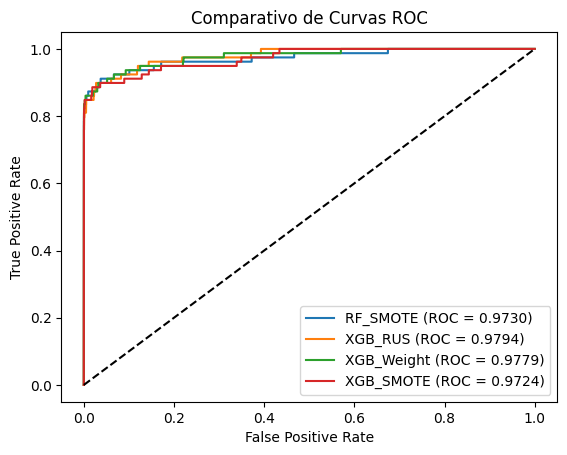

In [57]:
models = ["RF_SMOTE", "XGB_RUS", "XGB_Weight", "XGB_SMOTE"]

for model_name in models:

    model= results.get(model_name)

    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{model_name} (ROC = {roc:.4f})")

# Gráfico
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparativo de Curvas ROC")
plt.legend()
plt.show()

#### 🚀 Conclusão dos resultados

O uso da técnica de `SMOTE` no modelo do XGBoost teve um desempenho um pouco abaixo ao modelo de *Random Forest*, o que indica a inserção de ruído para esse modelo mais complexo, que confundiu levemente a fronteira de decisão.
- Além disso, pelo paradigma de correção de erros a cada iteração, em casos onde o `SMOTE` cria dados muito ruídosos, pode ocorrer um overfitting ao ruído.

Porém com a aplicação do `RandomUnderSampling`, foi possível obter uma melhora significativa, alcançando o melhor modelo global em comparativo a métrica de *ROC-AUC*. 
- Isso demonstra que o conjunto de dados original é bem informativo e a redução da classe de *Fraudes* consegue formar uma ótima fronteira de decisão com a correção dos erros.

O segundo melhor resultado global, o *XGB_Weight*, demonstra novamente a qualidade dos dados originais e como a penalização dos erros na função de custo, é uma estratégia eficiente e competitiva para esse modelo de Boosting.

> No fim, a transição para o *XGBoost* confirmou a hipótese de que o treinamento de árvores sequenciais conseguiria extrair o máximo de desempenho

---
### 5️⃣ Salvando Modelo e Métricas

- Arquivo `.pkl` com o melhor modelo (XGBoost com `RUS`)
- Arquivo `.csv` com as métricas e Hiperparâmetros do melhor modelo

In [59]:
folder_path = "./Model"
timestamp = datetime.now().strftime("%d-%H:%M:%S")    

model = results.get("XGB_RUS")

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

current_best_metrics = {
    "timestamp": timestamp,
    "model_name": "XGB_RUS",
    "roc_auc": roc_auc_score(y_test, y_proba),
    "precision": precision_score(y_test, y_pred, pos_label=1),
    "recall": recall_score(y_test, y_pred, pos_label=1),
    "best_params": str(model.best_params_) if hasattr(model, "best_params_") else "N/A"
}

model_filename = f"XGB_RUS_{timestamp}.pkl"
model_path = os.path.join(folder_path, model_filename)
joblib.dump(model, model_path)

csv_path = os.path.join(folder_path, "history_metrics.csv")
df_metrics = pd.DataFrame([current_best_metrics])

if not os.path.exists(csv_path):
    df_metrics.to_csv(csv_path, index=False)
else:
    df_metrics.to_csv(csv_path, mode="a", header=False, index=False)

print(f"Arquivos salvos com sucesso:\n- {model_path} \n- {csv_path}")

Arquivos salvos com sucesso:
- ./Model/XGB_RUS_21-00:15:50.pkl 
- ./Model/history_metrics.csv
